In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'


In [3]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_stability_after_switch'
misc.get_or_create_subdir(figdir)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)

'/mnt/home/szheng/ceph/place_variability/data/paper'

In [4]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

In [5]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all = prepped_data_agg['var_res_all']
corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']



ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])

ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 

In [6]:
# load metrics
import pickle
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
# pickle.dump(per_field_metrics_all,open(savefn_full,'wb'))
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

In [7]:
subdb_two_tasks = subdb.loc[[x.startswith('[') for x in subdb['behavior']]]
sess_two_tasks = subdb_two_tasks['sess_name']
best_n_all_sess_two_tasks = best_n_all.loc[(slice(None),sess_two_tasks)]

ii=2
ani,sess=sess_two_tasks.index[ii],sess_two_tasks.values[ii]
ani = ani[0]

In [8]:
import stability_analysis as sa

In [215]:
par_nosw_sw_df_relative_dropna[1].reset_index(level=0)

level_0     1
e13_26m1 e13_26m1_210913 0 0.0  27 0    nosw  -4.0
                                29 1    nosw   0.0
                                   2    nosw   2.0
                                30 0    nosw  12.0
                                31 0    nosw   3.0
...                                      ...   ...
e14_2m3  e14_2m3_201118  0 0.0  35 0      sw  -1.0
                                50 1      sw   7.0
                           both 3  0      sw   1.0
                                22 0      sw   7.0
                                23 0      sw  -3.0

[8189 rows x 2 columns]

# rate variability

In [9]:
def filter_by_si_simple(par_var_nosw_sw_df,per_field_metrics_all,si_thresh=0.5):
    si_thresh=0.5
    si_ma = per_field_metrics_all['si'] > si_thresh
    ind_intersect = si_ma.index.intersection(par_var_nosw_sw_df.index)
    par_var_nosw_sw_df_highsi=par_var_nosw_sw_df.loc[si_ma.loc[ind_intersect]]
    data = par_var_nosw_sw_df_highsi
    return data

In [13]:
def plot_strip_box(par_var_nosw_sw_df,per_field_metrics_all,
            par_key = 'fr_peak',
            var_func='cv',
            random_start = 2,
            nosw_start_pre_peak = False,
            nosw_start_pre_min=False,
            si_thresh=0.5,
            figsize = (3.9,2),
            savefig=False,
            figdir='',
                   
            ):
    x='isnovel'#'has_sw'
    y=f'{par_key}_{var_func}'
    hue='has_sw_int'#'has_sw'#'isnovel'
    fig,ax=plt.subplots(figsize=figsize)
    
    si_ma = per_field_metrics_all['si'] > si_thresh
    ind_intersect = si_ma.index.intersection(par_var_nosw_sw_df.index)
    par_var_nosw_sw_df_highsi=par_var_nosw_sw_df.loc[si_ma.loc[ind_intersect]]
    data = par_var_nosw_sw_df_highsi

    data['has_sw_int'] = data['has_sw'].apply(lambda x:{'nosw':0,'sw':1}[x])

    palette = {0:'C2',1:'C3'}

    sns.stripplot(data=data,x=x,y=y,hue=hue,ax=ax,order=[0,1],hue_order=[0,1],dodge=True,alpha=1,s=2.,palette=palette)
    sns.boxplot(data=data,x=x,y=y,hue=hue,ax=ax,order=[0,1],hue_order=[0,1],palette=palette)

    sns.despine()
    ax.set(ylabel=f'{var_func} (field {par_key})',xlabel='')
    ax.set_xticklabels(['Familiar','Novel'],fontsize=15)

    handles,labels=ax.get_legend_handles_labels()
    new_labels=['No Switch','Has switch-ON']
    ax.legend(handles[2:], new_labels,bbox_to_anchor=[0.9,1])

    ## add test
    from statannotations.Annotator import Annotator

    pairs = [
        ((0,0),(0,1)),
        ((1,0),(1,1)),
        ((0,0),(1,0)),
        ((0,1),(1,1)),
    ]


    annotator = Annotator(ax, pairs, data=data, x=x,hue=hue, y=y)
    annotator.configure(test='Mann-Whitney', text_format='star')#, loc='outside')
    annotator.apply_and_annotate()
    if savefig:
        for fmt in ['png','svg']:
            if random_start is not None:
                fn_full = f'{y}_vs_{x}_hue_{hue}_ntrials_after_sw_{ntrials_after_sw}_si_thresh_{si_thresh}_randomstart_{random_start}.{fmt}'
            elif nosw_start_pre_peak:
                fn_full = f'{y}_vs_{x}_hue_{hue}_ntrials_after_sw_{ntrials_after_sw}_si_thresh_{si_thresh}_nosw_start_pre_peak.{fmt}'
            elif nosw_start_pre_min:
                fn_full = f'{y}_vs_{x}_hue_{hue}_ntrials_after_sw_{ntrials_after_sw}_si_thresh_{si_thresh}_nosw_start_pre_min.{fmt}'                

            fn_full = os.path.join(figdir,fn_full)
            print(fn_full,' saved!')
            fig.savefig(fn_full,bbox_inches='tight')



/tmp/ipykernel_903044/131333641.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['has_sw_int'] = data['has_sw'].apply(lambda x:{'nosw':0,'sw':1}[x])


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_0 vs. 1_1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.880e-02 U_stat=3.971e+04
0_0 vs. 0_1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.602e-29 U_stat=1.566e+06
0_0 vs. 1_0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.906e-01 U_stat=4.731e+05
0_1 vs. 1_1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.778e-05 U_stat=7.253e+04


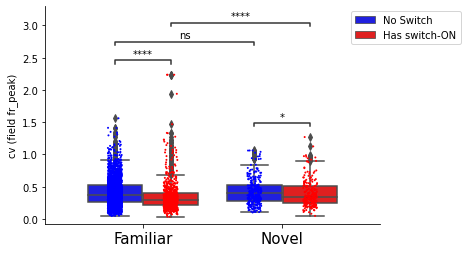

In [23]:
reload(sa)
par_key = 'fr_peak'
var_func='cv'
ntrials_after_sw = 5
nosw_start_frac = 0.5
nosw_start_pre_peak=False#True
par_var_nosw_sw_df,par_nosw_sw_df = sa.get_sw_no_sw_pf_par_var_control_ntrial(changes_df_all,pf_params_recombined_all,par_key=par_key,var_func=var_func,nosw_start_frac=nosw_start_frac,
                                                                              nosw_start_pre_peak=nosw_start_pre_peak,ntrials_after_sw=ntrials_after_sw,

                                                                             )


x='isnovel'#'has_sw'
y=f'{par_key}_{var_func}'
hue='has_sw_int'#'has_sw'#'isnovel'


fig,ax=plt.subplots()
# data = par_var_nosw_sw_df

si_thresh=0.5
si_ma = per_field_metrics_all['si'] > si_thresh
ind_intersect = si_ma.index.intersection(par_var_nosw_sw_df.index)
par_var_nosw_sw_df_highsi=par_var_nosw_sw_df.loc[si_ma.loc[ind_intersect]]
data = par_var_nosw_sw_df_highsi


data['has_sw_int'] = data['has_sw'].apply(lambda x:{'nosw':0,'sw':1}[x])

# palette = 'Blues'#{(0,0):'C0',(0,1):'C0',(1,0):'C1',(1,1):'C1'} #(x,hue)
palette = {0:'blue',1:'red'}

# sns.stripplot(data=data,x=x,y=y,hue=hue,ax=ax,order=['nosw','sw'],dodge=True,alpha=1,s=2.)
sns.stripplot(data=data,x=x,y=y,hue=hue,ax=ax,order=[0,1],hue_order=[0,1],dodge=True,alpha=1,s=2.,palette=palette)
# sns.boxplot(data=data,x=x,y=y,hue=hue,ax=ax,order=['nosw','sw'])
sns.boxplot(data=data,x=x,y=y,hue=hue,ax=ax,order=[0,1],hue_order=[0,1],palette=palette)

sns.despine()
ax.set(ylabel=f'{var_func} (field {par_key})',xlabel='')
# ax.set_xticklabels(['No switch','Switch ON'],fontsize=15)
ax.set_xticklabels(['Familiar','Novel'],fontsize=15)

handles,labels=ax.get_legend_handles_labels()
# new_labels=['Familiar','Novel']
new_labels=['No Switch','Has switch-ON']
ax.legend(handles[2:], new_labels,bbox_to_anchor=[0.9,1])

## add test
from statannotations.Annotator import Annotator

# pairs = [(0,2),(1,2),(0,1)]
# pairs = [
#     (('nosw',0),('sw',0)),
#     (('nosw',1),('sw',1)),
#     (('nosw',0),('nosw',1)),
#     (('sw',0),('sw',1)),
# ]
pairs = [
    ((0,0),(0,1)),
    ((1,0),(1,1)),
    ((0,0),(1,0)),
    ((0,1),(1,1)),
]


annotator = Annotator(ax, pairs, data=data, x=x,hue=hue, y=y)
annotator.configure(test='Mann-Whitney', text_format='star')#, loc='outside')
annotator.apply_and_annotate()

for fmt in ['png','svg']:
#     fig_fn = f'var_{par_key}_vs_sw_fam_nov.{fmt}'
#     fig_fn = f'{y}_vs_{x}_hue_{hue}_ntrials_after_sw_{ntrials_after_sw}.{fmt}'
    fig_fn = f'{y}_vs_{x}_hue_{hue}_ntrials_after_sw_{ntrials_after_sw}_si_thresh_{si_thresh}_noswstartfrac_{nosw_start_frac:.0e}.{fmt}'
    fig_fn_full = os.path.join(figdir,fig_fn)
#     fig.savefig(fig_fn_full,bbox_inches='tight')



# location variability

In [159]:
reload(sa)


<module 'stability_analysis' from '/mnt/home/szheng/projects/place_variability/code/stability_analysis.py'>

/tmp/ipykernel_903044/1331534388.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['has_sw_int'] = data['has_sw'].apply(lambda x:{'nosw':0,'sw':1}[x])


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_0 vs. 1_1: Mann-Whitney-Wilcoxon test two-sided, P_val:6.600e-01 U_stat=3.384e+04
0_0 vs. 0_1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.969e-08 U_stat=1.232e+06
0_0 vs. 1_0: Mann-Whitney-Wilcoxon test two-sided, P_val:9.222e-01 U_stat=4.238e+05
0_1 vs. 1_1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.697e-04 U_stat=7.460e+04


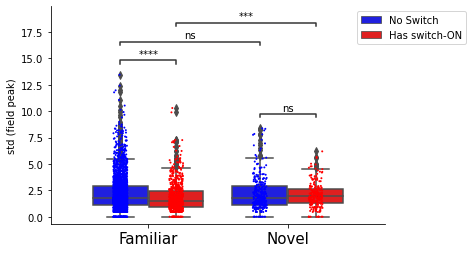

In [25]:
# for no sw, start trial later
# bc people might question whether the beginning of the task is inherently unstable

reload(sa)
par_key = 'peak'#'com'#'com'#'peak'
var_func='std'
ntrials_after_sw = 5
# nosw_start_trial = 2
# par_var_nosw_sw_df,par_nosw_sw_df = sa.get_sw_no_sw_pf_par_var_control_ntrial(changes_df_all,pf_params_recombined_all,par_key=par_key,var_func=var_func,min_size=nosw_start_trial,ntrials_after_sw=ntrials_after_sw)
nosw_start_frac = 0.5
nosw_start_pre_peak=False#True
random_start=4
par_var_nosw_sw_df,par_nosw_sw_df = sa.get_sw_no_sw_pf_par_var_control_ntrial(changes_df_all,pf_params_recombined_all,par_key=par_key,var_func=var_func,nosw_start_frac=nosw_start_frac,nosw_start_pre_peak=nosw_start_pre_peak,
                                                                              random_start=random_start,
                                                                              ntrials_after_sw=ntrials_after_sw)



x='isnovel'
y=f'{par_key}_{var_func}'
hue='has_sw_int'


fig,ax=plt.subplots()
si_thresh=0.5
si_ma = per_field_metrics_all['si'] > si_thresh
ind_intersect = si_ma.index.intersection(par_var_nosw_sw_df.index)
par_var_nosw_sw_df_highsi=par_var_nosw_sw_df.loc[si_ma.loc[ind_intersect]]
data = par_var_nosw_sw_df_highsi

# drift_thresh = 5#100#5
# par_nosw_sw_df_relative=par_nosw_sw_df - par_nosw_sw_df[0].values[:,None]
# par_nosw_sw_df_relative = par_nosw_sw_df_relative.unstack(level=0).loc[si_ma.loc[ind_intersect]].stack(level=1).reorder_levels((6,0,1,2,3,4,5))
# ma=(par_nosw_sw_df_relative.abs()<=drift_thresh).all(axis=1)
# data=par_nosw_sw_df_relative.loc[ma]
# data=data.std(axis=1).reset_index(level=(0,3)).rename({'level_0':'has_sw','level_3':'isnovel',0:y},axis=1)

data['has_sw_int'] = data['has_sw'].apply(lambda x:{'nosw':0,'sw':1}[x])


# palette = 'Blues'#{(0,0):'C0',(0,1):'C0',(1,0):'C1',(1,1):'C1'} #(x,hue)
# palette = {0:'C2',1:'C3'}
palette = {0:'blue',1:'red'}

# sns.stripplot(data=data,x=x,y=y,hue=hue,ax=ax,order=['nosw','sw'],dodge=True,alpha=1,s=2.)
sns.stripplot(data=data,x=x,y=y,hue=hue,ax=ax,order=[0,1],hue_order=[0,1],dodge=True,alpha=1,s=2.,palette=palette)
# sns.boxplot(data=data,x=x,y=y,hue=hue,ax=ax,order=['nosw','sw'])
sns.boxplot(data=data,x=x,y=y,hue=hue,ax=ax,order=[0,1],hue_order=[0,1],palette=palette)

sns.despine()
ax.set(ylabel=f'{var_func} (field {par_key})',xlabel='')
# ax.set_xticklabels(['No switch','Switch ON'],fontsize=15)
ax.set_xticklabels(['Familiar','Novel'],fontsize=15)

handles,labels=ax.get_legend_handles_labels()
# new_labels=['Familiar','Novel']
new_labels=['No Switch','Has switch-ON']
ax.legend(handles[2:], new_labels,bbox_to_anchor=[0.9,1])

## add test
from statannotations.Annotator import Annotator

# pairs = [(0,2),(1,2),(0,1)]
# pairs = [
#     (('nosw',0),('sw',0)),
#     (('nosw',1),('sw',1)),
#     (('nosw',0),('nosw',1)),
#     (('sw',0),('sw',1)),
# ]
pairs = [
    ((0,0),(0,1)),
    ((1,0),(1,1)),
    ((0,0),(1,0)),
    ((0,1),(1,1)),
]


annotator = Annotator(ax, pairs, data=data, x=x,hue=hue, y=y)
annotator.configure(test='Mann-Whitney', text_format='star')#, loc='outside')
annotator.apply_and_annotate()

for fmt in ['png','svg']:
#     fig_fn = f'var_{par_key}_vs_sw_fam_nov.{fmt}'
#     fig_fn = f'{y}_vs_{x}_hue_{hue}_ntrials_after_sw_{ntrials_after_sw}_y_change_thresh_{drift_thresh}.{fmt}'
    fig_fn = f'{y}_vs_{x}_hue_{hue}_ntrials_after_sw_{ntrials_after_sw}_si_thresh_{si_thresh}_noswstartfrac_{nosw_start_frac:.0e}.{fmt}'
    fig_fn_full = os.path.join(figdir,fig_fn)
#     fig.savefig(fig_fn_full,bbox_inches='tight')



In [146]:
# visualize some examples
# ii=13
# row=data.query('peak_std>7').iloc[ii]
# ani,sess,task_ind,tt,uid,field_id = row.name

# fig,ax=ph.heatmap(fr_map_trial_df_all.loc[ani,sess,task_ind,tt,uid].T)
# ax.set_title(row.name)

/tmp/ipykernel_903044/2658023382.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['has_sw_int'] = data['has_sw'].apply(lambda x:{'nosw':0,'sw':1}[x])


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_0 vs. 1_1: Mann-Whitney-Wilcoxon test two-sided, P_val:7.411e-01 U_stat=3.444e+04
0_0 vs. 0_1: Mann-Whitney-Wilcoxon test two-sided, P_val:6.580e-02 U_stat=1.217e+06
0_0 vs. 1_0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.758e-02 U_stat=4.352e+05
0_1 vs. 1_1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.479e-03 U_stat=7.481e+04


/tmp/ipykernel_903044/2658023382.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['has_sw_int'] = data['has_sw'].apply(lambda x:{'nosw':0,'sw':1}[x])


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_0 vs. 1_1: Mann-Whitney-Wilcoxon test two-sided, P_val:9.555e-01 U_stat=3.449e+04
0_0 vs. 0_1: Mann-Whitney-Wilcoxon test two-sided, P_val:4.373e-02 U_stat=1.108e+06
0_0 vs. 1_0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.214e-02 U_stat=3.874e+05
0_1 vs. 1_1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.479e-03 U_stat=7.481e+04


/tmp/ipykernel_903044/2658023382.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['has_sw_int'] = data['has_sw'].apply(lambda x:{'nosw':0,'sw':1}[x])


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_0 vs. 1_1: Mann-Whitney-Wilcoxon test two-sided, P_val:4.070e-01 U_stat=3.650e+04
0_0 vs. 0_1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.842e-03 U_stat=1.327e+06
0_0 vs. 1_0: Mann-Whitney-Wilcoxon test two-sided, P_val:3.687e-03 U_stat=4.530e+05
0_1 vs. 1_1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.479e-03 U_stat=7.481e+04
CPU times: user 26.4 s, sys: 61.6 ms, total: 26.5 s
Wall time: 26.5 s


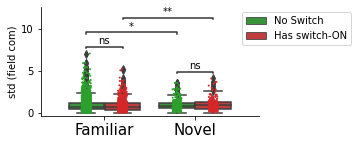

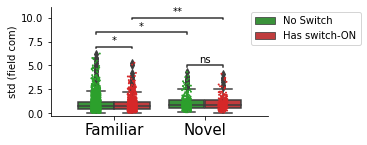

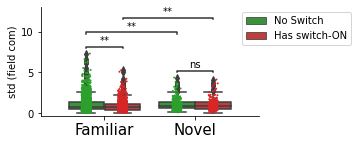

In [18]:
%%time
# loop multiple cases
## not changed in loop
nosw_start_trial = 2
nosw_start_frac = None
ntrials_pre_sw=0
ntrials_after_sw=5

si_thresh = 0.5
savefig = False#True

# for par_key,var_func in [['peak','std'],['fr_peak','cv']]:
for par_key,var_func in [['com','std']]:
    ## changing in loop
#     val_l = [[False,False,2],[False,False,4],[False,False,6],[True,False,None],[False,True,None]]
    val_l = [[False,False,2],[False,False,4],[False,False,None]]
    for val in val_l:
        nosw_start_pre_peak=val[0]
        nosw_start_pre_min=val[1]
        random_start =val[2]
        par_var_nosw_sw_df,par_nosw_sw_df = sa.get_sw_no_sw_pf_par_var_control_ntrial(changes_df_all,pf_params_recombined_all,par_key=par_key,var_func=var_func,min_size=nosw_start_trial,nosw_start_frac=nosw_start_frac,
                                                                                      random_start=random_start,
                                                                                      nosw_start_pre_peak=nosw_start_pre_peak,nosw_start_pre_min=nosw_start_pre_min,ntrials_after_sw=ntrials_after_sw,ntrials_pre_sw=ntrials_pre_sw)

        plot_strip_box(par_var_nosw_sw_df,per_field_metrics_all,
            par_key = par_key,
            var_func=var_func,
            random_start = random_start,
            nosw_start_pre_peak = nosw_start_pre_peak,
            nosw_start_pre_min=nosw_start_pre_min,
            si_thresh=si_thresh,
            savefig=savefig,
            figdir=figdir,
            )

# average drift trace

In [13]:
reload(sa)

<module 'stability_analysis' from '/mnt/home/szheng/projects/place_variability/code/stability_analysis.py'>

In [22]:
nosw_start_trial = 2#6#5#2
# par_var_nosw_sw_df,par_nosw_sw_df = sa.get_sw_no_sw_pf_par_var_control_ntrial(changes_df_all,pf_params_recombined_all,par_key=par_key,var_func=var_func,min_size=nosw_start_trial,ntrials_after_sw=ntrials_after_sw)
nosw_start_frac = None#0.7#0.7#0.4#0.5#None#
ntrials_pre_sw=0
nosw_start_pre_peak=False#True
nosw_start_pre_min=False#True
par_key='peak'#'fr_peak'
var_func = 'std'
ntrials_after_sw=5
random_start = 2#
par_var_nosw_sw_df,par_nosw_sw_df = sa.get_sw_no_sw_pf_par_var_control_ntrial(changes_df_all,pf_params_recombined_all,par_key=par_key,var_func=var_func,min_size=nosw_start_trial,nosw_start_frac=nosw_start_frac,
                                                                              random_start=random_start,
                                                                              nosw_start_pre_peak=nosw_start_pre_peak,nosw_start_pre_min=nosw_start_pre_min,ntrials_after_sw=ntrials_after_sw,ntrials_pre_sw=ntrials_pre_sw)


In [226]:
# # see what happen if i filter out the best/weird jump session
# ma = par_nosw_sw_df.index.get_level_values(2)!='e13_26m1_210913'
# par_nosw_sw_df=par_nosw_sw_df.loc[ma]

In [51]:
def get_relative_trace_filter_by_si(par_nosw_sw_df,per_field_metrics_all,trial_ind_relative=0,si_thresh=0.5):
    par_nosw_sw_df_relative=par_nosw_sw_df - par_nosw_sw_df[trial_ind_relative].values[:,None]
    si_ma = per_field_metrics_all['si'] > si_thresh
    ind_intersect = si_ma.index.intersection(par_var_nosw_sw_df.index)
    par_nosw_sw_df_relative = par_nosw_sw_df_relative.unstack(level=0).loc[si_ma.loc[ind_intersect]].stack(level=1).reorder_levels((6,0,1,2,3,4,5))
    ma=(par_nosw_sw_df_relative.abs()<=drift_thresh).all(axis=1)
    data=par_nosw_sw_df_relative.loc[ma]
    return data

def plot_drift_trace(par_nosw_sw_df,per_field_metrics_all,trial_ind_relative=0,
                     drift_thresh = 20,
                     si_thresh=0.5,
                     nosw_start_pre_peak=False,
                    nosw_start_pre_min=False,
                     random_start = 2,
                     savefig=False,
                     figdir=''
                    ):
    par_nosw_sw_df_relative=par_nosw_sw_df - par_nosw_sw_df[trial_ind_relative].values[:,None]
    si_ma = per_field_metrics_all['si'] > si_thresh
    ind_intersect = si_ma.index.intersection(par_var_nosw_sw_df.index)
    par_nosw_sw_df_relative = par_nosw_sw_df_relative.unstack(level=0).loc[si_ma.loc[ind_intersect]].stack(level=1).reorder_levels((6,0,1,2,3,4,5))
    ma=(par_nosw_sw_df_relative.abs()<=drift_thresh).all(axis=1)
    data=par_nosw_sw_df_relative.loc[ma]

    data_melt=data.groupby(level=(0,3)).apply(lambda x:x.melt()).reset_index(level=(0,1)).rename({'variable':'n_trial_after','value':'drift','level_0':'has_sw','level_1':'isnovel'},axis=1)
    data_melt = data_melt.reset_index(drop=True)


    palette={'nosw':'C2','sw':'C3'}

    isnovel_str_d={0:'Familiar',1:'Novel'}
    for isnovel in [0,1]:
        fig,ax=plt.subplots()
        ax.axhline(0,c='k',linestyle=':')
        sns.lineplot(data=data_melt.query('isnovel==@isnovel'),x='n_trial_after',y='drift',hue='has_sw',palette=palette,ax=ax,estimator='mean')
        sns.despine()
        ax.legend(bbox_to_anchor=[0.9,1.])
        ax.set(ylabel='Drift',xlabel='Trial (relative)')
        ax.set(xticks=par_nosw_sw_df.columns)
        ax.set_title(isnovel_str_d[isnovel])

        handles,labels=ax.get_legend_handles_labels()
        new_labels=['No switch','Has switch ON']
        ax.legend(handles, new_labels)

        if savefig:
            for fmt in ['png','svg']:
        #         fn_full = f'{par_key}_drift_vs_trial_ntrials_after_sw_{ntrials_after_sw}_isnovel_{isnovel}_si_thresh_{si_thresh:.0e}_noswstartfrac_{nosw_start_frac:.0e}.{fmt}'
                if random_start is not None:
                    fn_full = f'{par_key}_drift_vs_trial_ntrials_after_sw_{ntrials_after_sw}_isnovel_{isnovel}_si_thresh_{si_thresh:.0e}_randomstart_{random_start}.{fmt}'
                elif nosw_start_pre_peak:
                    fn_full = f'{par_key}_drift_vs_trial_ntrials_after_sw_{ntrials_after_sw}_isnovel_{isnovel}_si_thresh_{si_thresh:.0e}_nosw_start_pre_peak.{fmt}'
                elif nosw_start_pre_min:
                    fn_full = f'{par_key}_drift_vs_trial_ntrials_after_sw_{ntrials_after_sw}_isnovel_{isnovel}_si_thresh_{si_thresh:.0e}_nosw_start_pre_min.{fmt}'                

                fn_full = os.path.join(figdir,fn_full)
                print(fn_full,' saved!')
                fig.savefig(fn_full,bbox_inches='tight')



/mnt/home/szheng/ceph/place_variability/fig/paper/figure_stability_after_switch/com_drift_vs_trial_ntrials_after_sw_5_isnovel_0_si_thresh_5e-01_randomstart_2.png  saved!
/mnt/home/szheng/ceph/place_variability/fig/paper/figure_stability_after_switch/com_drift_vs_trial_ntrials_after_sw_5_isnovel_0_si_thresh_5e-01_randomstart_2.svg  saved!
/mnt/home/szheng/ceph/place_variability/fig/paper/figure_stability_after_switch/com_drift_vs_trial_ntrials_after_sw_5_isnovel_1_si_thresh_5e-01_randomstart_2.png  saved!
/mnt/home/szheng/ceph/place_variability/fig/paper/figure_stability_after_switch/com_drift_vs_trial_ntrials_after_sw_5_isnovel_1_si_thresh_5e-01_randomstart_2.svg  saved!
/mnt/home/szheng/ceph/place_variability/fig/paper/figure_stability_after_switch/com_drift_vs_trial_ntrials_after_sw_5_isnovel_0_si_thresh_5e-01_randomstart_4.png  saved!
/mnt/home/szheng/ceph/place_variability/fig/paper/figure_stability_after_switch/com_drift_vs_trial_ntrials_after_sw_5_isnovel_0_si_thresh_5e-01_random

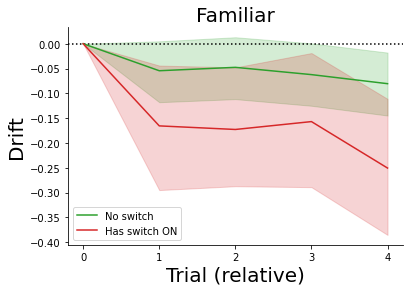

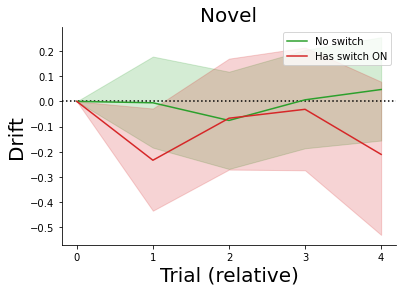

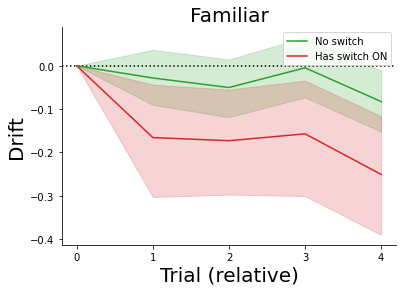

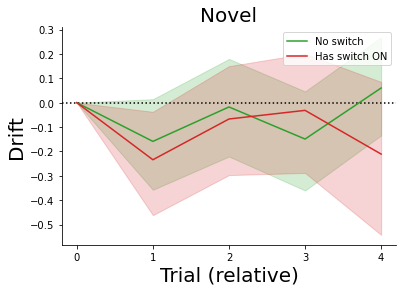

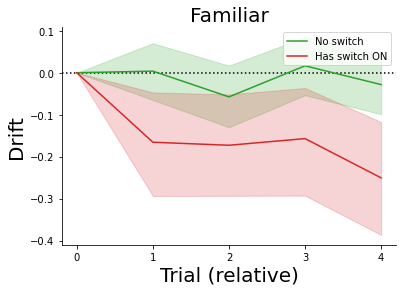

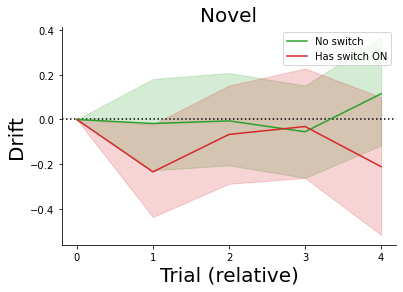

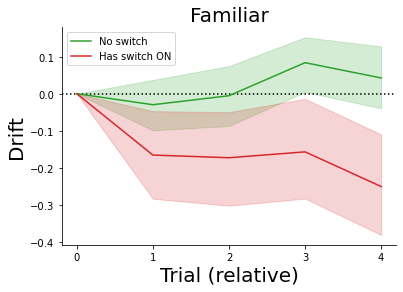

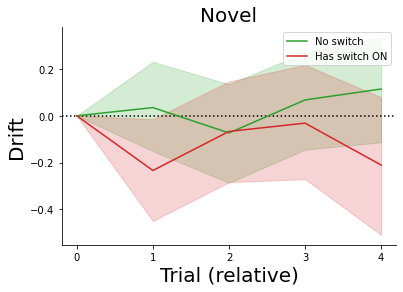

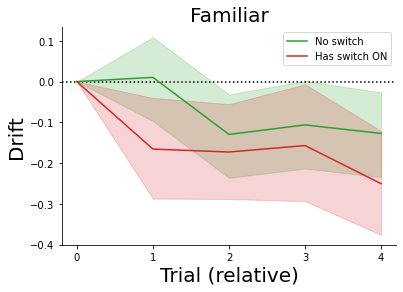

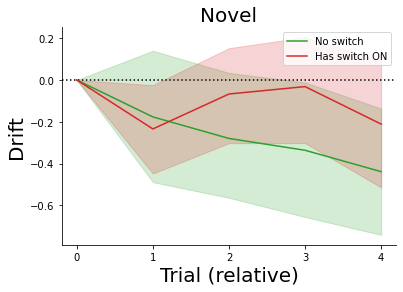

In [184]:
%%time
# loop multiple cases
## not changed in loop
reload(sa)
nosw_start_trial = 2
par_key='com'#'peak'
var_func = 'std'
nosw_start_frac = None
ntrials_pre_sw=0
ntrials_after_sw=5

si_thresh = 0.5
savefig = True

## changing in loop
val_l = [[False,False,2],[False,False,4],[False,False,6],[True,False,None],[False,True,None]]
for val in val_l:
    nosw_start_pre_peak=val[0]
    nosw_start_pre_min=val[1]
    random_start =val[2]
    par_var_nosw_sw_df,par_nosw_sw_df = sa.get_sw_no_sw_pf_par_var_control_ntrial(changes_df_all,pf_params_recombined_all,par_key=par_key,var_func=var_func,min_size=nosw_start_trial,nosw_start_frac=nosw_start_frac,
                                                                                  random_start=random_start,
                                                                                  nosw_start_pre_peak=nosw_start_pre_peak,nosw_start_pre_min=nosw_start_pre_min,ntrials_after_sw=ntrials_after_sw,ntrials_pre_sw=ntrials_pre_sw)
    
    
    plot_drift_trace(par_nosw_sw_df,per_field_metrics_all,trial_ind_relative=0,
                         si_thresh=si_thresh,
                         nosw_start_pre_peak=nosw_start_pre_peak,
                        nosw_start_pre_min=nosw_start_pre_min,
                         random_start = random_start,
                         savefig=savefig,
                         figdir=figdir
                        )

    

/mnt/home/szheng/ceph/place_variability/fig/paper/figure_stability_after_switch/peak_drift_vs_trial_ntrials_after_sw_5_isnovel_0_si_thresh_5e-01_randomstart_2.png  saved!
/mnt/home/szheng/ceph/place_variability/fig/paper/figure_stability_after_switch/peak_drift_vs_trial_ntrials_after_sw_5_isnovel_0_si_thresh_5e-01_randomstart_2.svg  saved!
/mnt/home/szheng/ceph/place_variability/fig/paper/figure_stability_after_switch/peak_drift_vs_trial_ntrials_after_sw_5_isnovel_1_si_thresh_5e-01_randomstart_2.png  saved!
/mnt/home/szheng/ceph/place_variability/fig/paper/figure_stability_after_switch/peak_drift_vs_trial_ntrials_after_sw_5_isnovel_1_si_thresh_5e-01_randomstart_2.svg  saved!


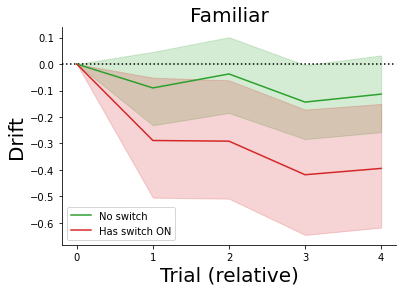

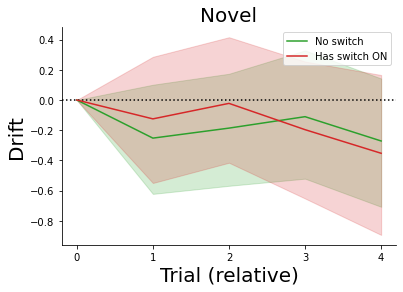

In [34]:
si_thresh = 0.5
savefig = True
plot_drift_trace(par_nosw_sw_df,per_field_metrics_all,trial_ind_relative=0,
                     si_thresh=si_thresh,
                     nosw_start_pre_peak=nosw_start_pre_peak,
                    nosw_start_pre_min=nosw_start_pre_min,
                     random_start = random_start,
                     savefig=savefig,
                     figdir=figdir
                    )


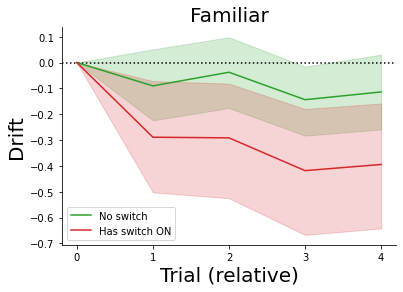

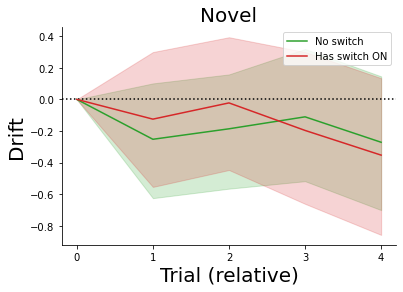

In [23]:
drift_thresh = 20#5#10
trial_ind_relative=0
par_nosw_sw_df_relative=par_nosw_sw_df - par_nosw_sw_df[trial_ind_relative].values[:,None]
si_thresh=0.5
si_ma = per_field_metrics_all['si'] > si_thresh
ind_intersect = si_ma.index.intersection(par_var_nosw_sw_df.index)
par_nosw_sw_df_relative = par_nosw_sw_df_relative.unstack(level=0).loc[si_ma.loc[ind_intersect]].stack(level=1).reorder_levels((6,0,1,2,3,4,5))
ma=(par_nosw_sw_df_relative.abs()<=drift_thresh).all(axis=1)
data=par_nosw_sw_df_relative.loc[ma]

data_melt=data.groupby(level=(0,3)).apply(lambda x:x.melt()).reset_index(level=(0,1)).rename({'variable':'n_trial_after','value':'drift','level_0':'has_sw','level_1':'isnovel'},axis=1)
data_melt = data_melt.reset_index(drop=True)


palette={'nosw':'C2','sw':'C3'}

isnovel_str_d={0:'Familiar',1:'Novel'}
for isnovel in [0,1]:
    fig,ax=plt.subplots()
    ax.axhline(0,c='k',linestyle=':')
    sns.lineplot(data=data_melt.query('isnovel==@isnovel'),x='n_trial_after',y='drift',hue='has_sw',palette=palette,ax=ax,estimator='mean')
    sns.despine()
    ax.legend(bbox_to_anchor=[0.9,1.])
    ax.set(ylabel='Drift',xlabel='Trial (relative)')
    ax.set(xticks=par_nosw_sw_df.columns)
    ax.set_title(isnovel_str_d[isnovel])
    
    handles,labels=ax.get_legend_handles_labels()
    new_labels=['No switch','Has switch ON']
    ax.legend(handles, new_labels)
    
    
    for fmt in ['png','svg']:
#         fn_full = f'{par_key}_drift_vs_trial_ntrials_after_sw_{ntrials_after_sw}_isnovel_{isnovel}_si_thresh_{si_thresh:.0e}_noswstartfrac_{nosw_start_frac:.0e}.{fmt}'
        fn_full = f'{par_key}_drift_vs_trial_ntrials_after_sw_{ntrials_after_sw}_isnovel_{isnovel}_si_thresh_{si_thresh:.0e}_randomstart_{random_start}.{fmt}'
        fn_full = os.path.join(figdir,fn_full)
#         fig.savefig(fn_full,bbox_inches='tight')




In [351]:
data.index.get_level_values(2).unique()

Index(['e13_16f1_210302', 'e13_16f1_210312', 'e13_16f1_210314',
       'e13_16f1_210317', 'e13_16f1_210319', 'e13_16f1_210322',
       'e13_16f1_210328', 'e13_16f1_210331', 'e13_26m1_210913',
       'e13_26m1_211019', 'e13_26m1_211116', 'e13_26m1_211119',
       'e13_26m1_211124', 'e14_2m2_201017', 'e14_2m2_201019', 'e14_2m3_201118',
       'e14_2m3_201121', 'e14_2m3_201125', 'e14_2m3_201129', 'e14_2m3_201206',
       'e14_2m3_201208', 'e15_10m1_200727', 'e15_10m1_200803',
       'e15_10m1_200809', 'e15_10m1_200812', 'e15_13f1_220117',
       'e15_13f1_220118', 'e15_13f1_220119', 'e15_13f1_220120',
       'e15_9f1_200715', 'e15_9f1_200720', 'e15_9f1_200723', 'e15_9f1_200729',
       'e15_9f1_200802', 'e16_1f1_200918', 'e16_1f1_200919', 'e16_1f1_200920',
       'e16_1f1_200923', 'e16_1f1_201004', 'e16_2m1_201121', 'e16_3m1_210119',
       'e16_3m1_210201', 'e16_3m1_210203', 'e16_3m2_211210', 'e16_3m2_211212',
       'e16_3m2_211213'],
      dtype='object')

In [340]:
data.index.get_level_values(1).unique()

Index(['e13_16f1', 'e13_26m1', 'e14_2m2', 'e14_2m3', 'e15_10m1', 'e15_13f1',
       'e15_9f1', 'e16_1f1', 'e16_2m1', 'e16_3m1', 'e16_3m2'],
      dtype='object')

(<Figure size 432x288 with 1 Axes>, <Axes: >)

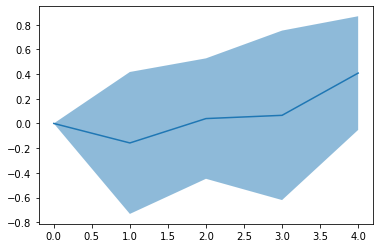

In [408]:
# ph.mean_error_plot(data.loc[('nosw','e16_3m2'),:])
ph.mean_error_plot(data.loc[('sw',slice(None),'e15_13f1_220120',0),:])

In [414]:
mat=data.loc[('sw',slice(None),'e15_13f1_220120',0),:]
mat[4].idxmax()

('sw', 'e15_13f1', 'e15_13f1_220120', 0, 0.0, 97, 0)

# total drift begin to end

In [261]:
nosw_start_trial = 0
par_key='peak'
var_func = 'std'
nosw_start_frac = None
ntrials_pre_sw=0
ntrials_after_sw=100

si_thresh = 0.5
savefig = False#True


random_start=None
nosw_start_pre_peak=False
nosw_start_pre_min=False
par_var_nosw_sw_df,par_nosw_sw_df = sa.get_sw_no_sw_pf_par_var_control_ntrial(changes_df_all,pf_params_recombined_all,par_key=par_key,var_func=var_func,min_size=nosw_start_trial,nosw_start_frac=nosw_start_frac,
                                                                                  random_start=random_start,
                                                                                  nosw_start_pre_peak=nosw_start_pre_peak,nosw_start_pre_min=nosw_start_pre_min,ntrials_after_sw=ntrials_after_sw,ntrials_pre_sw=ntrials_pre_sw)



In [294]:
data

0     1     2     3     4     5   \
e13_26m1 e13_26m1_210913 0 0.0  3  0   NaN  24.0   NaN  25.0   NaN   NaN   
                                27 0   NaN  22.0   NaN   0.0   NaN   NaN   
                                29 0   NaN   6.0   NaN   9.0   NaN   NaN   
                                   1   NaN  21.0   NaN  21.0   NaN   NaN   
                                   2   NaN  79.0   NaN  76.0   NaN   NaN   
...                                    ...   ...   ...   ...   ...   ...   
e14_2m3  e14_2m3_201118  0 both 30 0  23.0  19.0  15.0  14.0  18.0  13.0   
                                32 0   5.0   5.0   6.0   8.0  11.0  17.0   
                                38 0   0.0   7.0   0.0   0.0   0.0   0.0   
                                47 0   4.0  10.0   4.0   9.0   8.0   5.0   
                                53 0   4.0   0.0   0.0   4.0   0.0   0.0   

                                        6     7     8     9   ...  60    61  \
e13_26m1 e13_26m1_210913 0 0.0  3  0  30.0   NaN  24.0   NaN  ... NaN  32.0   
                                27 0  12.0   NaN  26.0   NaN  ... NaN  20.0   
                                29 0   2.0   NaN   7.0   NaN  ... NaN   6.0   
                                   1  22.0   NaN  23.0   NaN  ... NaN  33.0   
                                   2  74.0   NaN  73.0   NaN  ... NaN  80.0   
...                                    ...   ...   ...   ...  ...  ..   ...   
e14_2m3  e14_2m3_201118  0 both 30 0  12.0   8.0  14.0  13.0  ... NaN   NaN   
                                32 0   8.0  26.0   8.0  16.0  ... NaN   NaN   
                                38 0   0.0   0.0   0.0   0.0  ... NaN   NaN   
                                47 0   2.0   8.0   5.0   9.0  ... NaN   NaN   
                                53 0   4.0   4.0   6.0   1.0  ... NaN   NaN   

                                      62    63  64    65  66  67    68  69  
e13_26m1 e13_26m1_210913 0 0.0  3  0 NaN  31.0 NaN  31.0 NaN NaN  34.0 NaN  
                                27 0 NaN  19.0 NaN  26.0 NaN NaN   0.0 NaN  
                                29 0 NaN   7.0 NaN   9.0 NaN NaN   6.0 NaN  
                                   1 NaN  30.0 NaN  30.0 NaN NaN  29.0 NaN  
                                   2 NaN  79.0 NaN  75.0 NaN NaN  69.0 NaN  
...                                   ..   ...  ..   ...  ..  ..   ...  ..  
e14_2m3  e14_2m3_201118  0 both 30 0 NaN   NaN NaN   NaN NaN NaN   NaN NaN  
                                32 0 NaN   NaN NaN   NaN NaN NaN   NaN NaN  
                                38 0 NaN   NaN NaN   NaN NaN NaN   NaN NaN  
                                47 0 NaN   NaN NaN   NaN NaN NaN   NaN NaN  
                                53 0 NaN   NaN NaN   NaN NaN NaN   NaN NaN  

[14438 rows x 70 columns]

In [341]:
par_name = 'com'
data=pf_params_recombined_all.loc[(slice(None),slice(None),par_name),:].droplevel(2)
data=filter_by_si_simple(data,per_field_metrics_all,si_thresh=0.5)
ntrial_win = 3
drift_diff_res_all = {}
for k,val in data.groupby(level=(0,1,2,3)):
    val = val.loc[k].dropna(axis=1,how='all')
#     beg_end_diff = val.iloc[:,:ntrial_win].median(axis=1) - val.iloc[:,-ntrial_win:].median(axis=1)
    beg_end_diff = val.iloc[:,:ntrial_win].mean(axis=1) - val.iloc[:,-ntrial_win:].mean(axis=1)
    beg_end_diff_div_ntrial = beg_end_diff / (val.shape[1] - (2*ntrial_win))
    diff_sum_square = (val.diff(axis=1)**2).sum(axis=1)
    mean_sum_square = (val.diff(axis=1)**2).mean(axis=1)
    drift_diff_res = {'beg_end_diff':beg_end_diff,'beg_end_diff_div_ntrial':beg_end_diff_div_ntrial,'diff_sum_square':diff_sum_square,'mean_sum_square':mean_sum_square}
    drift_diff_res_all[k] = pd.concat(drift_diff_res,axis=1)
drift_diff_res_all = pd.concat(drift_diff_res_all,axis=0)
drift_diff_res_all['beg_end_diff_square'] = drift_diff_res_all['beg_end_diff']**2
    

In [342]:
ma_d = {}
for on_count in [0,1]:
    ma = ((changes_df_all==1).sum(axis=1)==on_count) 
    ma_d[on_count] = ma

In [343]:
ind = drift_diff_res_all.index
for hassw in [0,1]:
    common_ind = ma_d[hassw].index.intersection(ind)
    drift_diff_res_all.loc[ma_d[hassw].loc[common_ind],'has_sw_on'] = hassw

<Axes: xlabel='beg_end_diff_square', ylabel='mean_sum_square'>

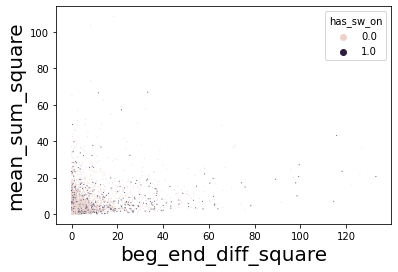

In [348]:
x='beg_end_diff_square'#'beg_end_diff'
y='mean_sum_square'#'diff_sum_square'#
hue = 'has_sw_on'
sns.scatterplot(data=drift_diff_res_all,x=x,y=y,hue=hue,s=1)

In [383]:
ani='e13_26m1'
sess='e13_26m1_211019'#'e15_13f1_220117'
drift_diff_res_all_sub=drift_diff_res_all.loc[ani,sess]
ma=drift_diff_res_all_sub['beg_end_diff'].abs() > 5
ii=3
row=drift_diff_res_all_sub.loc[ma].iloc[ii]
task_ind,tt,uid,field_id=row.name

beg_end_diff                -6.145827
beg_end_diff_div_ntrial     -0.292658
diff_sum_square            780.889054
mean_sum_square             30.034194
has_sw_on                    0.000000
beg_end_diff_square         37.771194
Name: (0, 0.0, 150, 0), dtype: float64


/tmp/ipykernel_129530/1077509902.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  fig,ax=ph.ratemap_one_raw(fr_map_trial_df_all.loc[ani,sess,task_ind,ttr,uid].T.dropna(axis=0,how='all'),


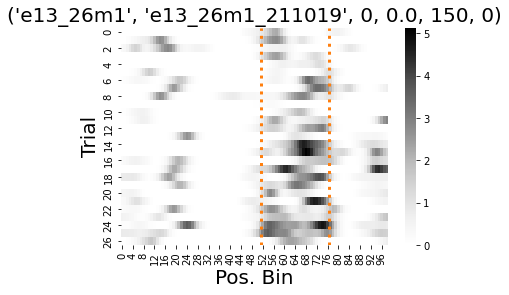

In [384]:
# row=data_sub.loc[ma].iloc[ii]

# uid,field_id=beg_end_diff.index[ii]
# uid,field_id=151,0
# ani,sess,task_ind,tt=k
#     task_ind,tt,uid,field_id=row.name


print(row)
if tt=='both':
    ttr=0
else:
    ttr=tt

field_bound = all_fields_recombined_all.loc[ani,sess,task_ind,tt,uid,field_id][['start','end']]
# sw_trial=all_sw_d_all.loc[ani,sess,task_ind].query('trialtype==@tt&uid==@uid&field_index==@field_id')['index_within'].iloc[0]
sw_trial=None
fig,ax=ph.ratemap_one_raw(fr_map_trial_df_all.loc[ani,sess,task_ind,ttr,uid].T.dropna(axis=0,how='all'),
                   trial=sw_trial,field_bound=field_bound,
                  )
ax.set_title((ani,sess,task_ind,tt,uid,field_id))
#     xticks=np.arange(0,99,10)
#     ax.set_xticks(xticks)
#     ax.set_xticklabels(xticks)
ax.set(xlabel='Pos. Bin',ylabel='Trial')
for fmt in ['svg','png']:
    fn_full = f'{sess}_task{int(task_ind)}_tt{tt}_uid{uid}_field{field_id}.{fmt}'
#         fig.savefig(os.path.join(figdirsupp,fn_full),bbox_inches='tight')

# ax.set_ylim([sw_trial+5,sw_trial-1])
# ax.set_xlim([field_bound[0]-20,field_bound[1]+20])

In [381]:
two_par_one=pf_params_recombined_all.loc[(ani,sess,['com','fr_peak'],task_ind,tt,uid,field_id),:].dropna(axis=1,how='all')




In [382]:
two_par_one.iloc[0].loc[two_par_one.iloc[1]>6]

25    66.676489
27    66.231657
29    65.006646
33    66.448803
34    64.942421
35    65.354028
37    68.477493
38    66.368476
42    67.542580
44    67.304912
Name: (e13_26m1, e13_26m1_211019, com, 0, 0.0, 148, 0), dtype: float64

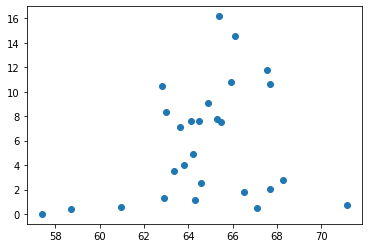

In [373]:
plt.scatter(two_par_one.iloc[0],two_par_one.iloc[1])

In [286]:
beg_end_diff

11   1    10.0
16   0     1.0
23   0     7.0
25   0     0.0
26   0    -3.0
28   0     1.0
33   0     4.0
34   0     0.0
36   0    -1.0
46   0    -5.0
56   0     0.0
61   0    -3.0
62   0     6.0
74   0     5.0
98   0    -3.0
109  0     3.0
114  1     1.0
117  0     4.0
124  0     2.0
126  0     2.0
127  0     0.0
136  0    -1.0
144  0    -6.0
151  0     4.0
157  0     3.0
190  0     3.0
192  0     0.0
195  0     1.0
dtype: float64

In [278]:
val.loc[k].dropna(axis=1,how='all')

,,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
11,1,32.0,34.0,30.0,30.0,28.0,25.0,26.0,21.0,23.0,20.0,...,22.0,20.0,24.0,25.0,20.0,30.0,18.0,34.0,22.0,22.0
16,0,7.0,9.0,14.0,9.0,8.0,14.0,10.0,5.0,10.0,11.0,...,2.0,5.0,8.0,8.0,0.0,12.0,11.0,9.0,8.0,5.0
23,0,16.0,16.0,14.0,13.0,14.0,11.0,14.0,7.0,4.0,3.0,...,5.0,3.0,6.0,0.0,0.0,10.0,7.0,0.0,9.0,10.0
25,0,20.0,11.0,15.0,14.0,18.0,12.0,14.0,15.0,16.0,13.0,...,13.0,16.0,15.0,16.0,16.0,16.0,15.0,15.0,16.0,14.0
26,0,4.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,0.0,1.0,0.0,2.0,0.0,0.0,0.0,3.0,4.0,0.0
28,0,22.0,21.0,21.0,23.0,22.0,21.0,21.0,20.0,23.0,21.0,...,21.0,24.0,25.0,19.0,18.0,20.0,22.0,20.0,22.0,19.0
33,0,11.0,17.0,17.0,18.0,16.0,14.0,15.0,15.0,17.0,14.0,...,15.0,5.0,8.0,0.0,7.0,4.0,15.0,13.0,5.0,13.0
34,0,14.0,8.0,11.0,10.0,9.0,8.0,4.0,4.0,4.0,3.0,...,10.0,5.0,8.0,10.0,13.0,14.0,15.0,12.0,7.0,11.0
36,0,6.0,8.0,9.0,1.0,8.0,6.0,6.0,6.0,7.0,6.0,...,6.0,5.0,10.0,6.0,6.0,10.0,10.0,1.0,9.0,9.0
46,0,0.0,2.0,5.0,12.0,7.0,6.0,6.0,7.0,13.0,6.0,...,7.0,7.0,7.0,8.0,6.0,5.0,8.0,7.0,9.0,6.0


In [266]:
gpb=par_nosw_sw_df.groupby(level=(0,1,2,3))
for k,val in gpb:
    val

In [269]:
val.dropna(axis=1,how='all')

0     1     2     3     4     5   \
sw e16_3m2 e16_3m2_211213 1 0.0  11  3  62.0  69.0  75.0  72.0  71.0  72.0   
                                 12  0  31.0  30.0  30.0  30.0   NaN   NaN   
                                 18  1  39.0  41.0  37.0  39.0  40.0  41.0   
                                 30  0  25.0  25.0  27.0  25.0  21.0  22.0   
                                 47  0  24.0  23.0  21.0  20.0  20.0  24.0   
                                 51  0  37.0  35.0  37.0  39.0  38.0  39.0   
                                 55  0  22.0  24.0  19.0  25.0  19.0  19.0   
                                 60  0  42.0  42.0  44.0  43.0  43.0  44.0   
                                 61  1  28.0  26.0  25.0  25.0  27.0   NaN   
                                 62  1  44.0  44.0  43.0  46.0  44.0   NaN   
                                 66  1  71.0  73.0  75.0  64.0  75.0  61.0   
                                 71  0  49.0  46.0  47.0  49.0  45.0   NaN   
                                 93  1  66.0  72.0  71.0  67.0  62.0  68.0   
                                 100 1  71.0  64.0  66.0  61.0  62.0  75.0   
                                 110 0  35.0  31.0  30.0  31.0   NaN   NaN   
                                 112 0  75.0  70.0  71.0  71.0  67.0  75.0   
                                 113 0  33.0  31.0  34.0  36.0  31.0  29.0   
                                 122 1  28.0  29.0  31.0  28.0  28.0  25.0   
                                 123 0  62.0  62.0  59.0  61.0  59.0  61.0   
                                 149 0  64.0  62.0  61.0  66.0  59.0   NaN   
                                 166 0  26.0  28.0  21.0  26.0  25.0  21.0   
                                 185 1  68.0  69.0  75.0  70.0  68.0  70.0   
                                 187 0   1.0  10.0   NaN   NaN   NaN   NaN   
                                 205 2  75.0  73.0  75.0  75.0  73.0  75.0   
                            1.0  11  2  75.0  75.0  75.0  75.0  75.0  75.0   
                                 13  0  37.0  38.0  36.0  37.0  39.0  38.0   
                                 19  1  47.0  47.0  42.0  45.0   NaN   NaN   
                                 30  0  26.0  28.0  32.0  30.0  28.0   NaN   
                                     1  73.0  75.0   NaN   NaN   NaN   NaN   
                                 47  0  22.0  23.0  25.0  20.0  19.0  22.0   
                                 51  1  58.0  55.0  57.0  47.0  51.0  49.0   
                                 55  0  21.0  19.0  20.0  24.0  24.0  18.0   
                                 56  2  65.0  72.0  67.0   NaN   NaN   NaN   
                                 59  0  20.0  17.0  19.0  17.0  17.0  18.0   
                                 66  1  75.0  75.0  75.0  75.0  75.0  69.0   
                                 74  1  60.0  57.0  56.0   NaN   NaN   NaN   
                                 100 0  32.0  31.0  30.0  29.0  31.0  30.0   
                                     1  73.0  75.0  75.0  75.0  75.0  75.0   
                                 127 1  59.0  60.0  60.0  56.0  55.0   NaN   
                                 148 0  70.0  70.0  68.0  67.0  64.0  64.0   
                                 169 0  55.0  53.0  54.0  51.0  51.0  58.0   
                                 192 1  36.0  34.0  35.0   NaN   NaN   NaN   
                                 200 2  61.0  53.0   NaN   NaN   NaN   NaN   
                            both 16  0   0.0   9.0  10.0   6.0  10.0   6.0   
                                 23  0   3.0   6.0   6.0   6.0   8.0   4.0   
                                 26  0   0.0   2.0   0.0   0.0   1.0   0.0   
                                 34  0  12.0   7.0  11.0   NaN   NaN   NaN   
                                 36  0   9.0   9.0   NaN   NaN   NaN   NaN   
                                 74  0  23.0  21.0  25.0  23.0  23.0  21.0   
                                 109 0   8.0   7.0   8.0   5.0   5.0   6.0   
                                 124 0   0.0   0.0   0.0   0.0  

# example drifts

## backward drift of pop up

In [185]:
nosw_start_trial = 2
par_key='com'#'peak'
var_func = 'std'
nosw_start_frac = None
ntrials_pre_sw=0
ntrials_after_sw=5

si_thresh = 0.5
savefig = False#True


random_start=None
nosw_start_pre_peak=True
nosw_start_pre_min=False
par_var_nosw_sw_df,par_nosw_sw_df = sa.get_sw_no_sw_pf_par_var_control_ntrial(changes_df_all,pf_params_recombined_all,par_key=par_key,var_func=var_func,min_size=nosw_start_trial,nosw_start_frac=nosw_start_frac,
                                                                                  random_start=random_start,
                                                                                  nosw_start_pre_peak=nosw_start_pre_peak,nosw_start_pre_min=nosw_start_pre_min,ntrials_after_sw=ntrials_after_sw,ntrials_pre_sw=ntrials_pre_sw)



In [48]:
# data = filter_by_si_simple(par_var_nosw_sw_df,per_field_metrics_all,si_thresh=0.5)

In [186]:
data=get_relative_trace_filter_by_si(par_nosw_sw_df,per_field_metrics_all,trial_ind_relative=0,si_thresh=0.5)

In [187]:
data.index.get_level_values(2).unique()

Index(['e13_16f1_210302', 'e13_16f1_210312', 'e13_16f1_210314',
       'e13_16f1_210317', 'e13_16f1_210319', 'e13_16f1_210322',
       'e13_16f1_210328', 'e13_16f1_210331', 'e13_26m1_210913',
       'e13_26m1_211019', 'e13_26m1_211116', 'e13_26m1_211119',
       'e13_26m1_211124', 'e14_2m2_201017', 'e14_2m2_201019', 'e14_2m3_201118',
       'e14_2m3_201121', 'e14_2m3_201125', 'e14_2m3_201129', 'e14_2m3_201206',
       'e14_2m3_201208', 'e15_10m1_200727', 'e15_10m1_200803',
       'e15_10m1_200809', 'e15_10m1_200812', 'e15_13f1_220117',
       'e15_13f1_220118', 'e15_13f1_220119', 'e15_13f1_220120',
       'e15_9f1_200715', 'e15_9f1_200720', 'e15_9f1_200723', 'e15_9f1_200729',
       'e15_9f1_200802', 'e16_1f1_200918', 'e16_1f1_200919', 'e16_1f1_200920',
       'e16_1f1_200923', 'e16_1f1_201004', 'e16_2m1_201121', 'e16_3m1_210119',
       'e16_3m1_210201', 'e16_3m1_210203', 'e16_3m2_211210', 'e16_3m2_211212',
       'e16_3m2_211213'],
      dtype='object')

In [257]:
ani='e13_26m1'
sess='e13_26m1_211019'#'e15_13f1_220117'

In [232]:
data_sub.loc[ma]

,,,0,1,2,3,4
both,126,0,0.0,-6.87933,-4.197523,-4.661013,-5.507789


In [254]:
figdirsupp = misc.get_or_create_subdir(figdir,'drift_examples')

/mnt/home/szheng/ceph/place_variability/fig/paper/figure_stability_after_switch/drift_examples made!


/tmp/ipykernel_129530/1381779032.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  data_sub=data.loc['sw',ani,sess,task_ind]
/tmp/ipykernel_129530/1381779032.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  sw_trial=all_sw_d_all.loc[ani,sess,task_ind].query('trialtype==@tt&uid==@uid&field_index==@field_id')['index_within'].iloc[0]
/tmp/ipykernel_129530/1381779032.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  fig,ax=ph.ratemap_one_raw(fr_map_trial_df_all.loc[ani,sess,task_ind,ttr,uid].T.dropna(axis=0,how='all'),


0    0.000000
1   -3.596725
2   -2.482060
3   -2.203636
4   -5.817483
Name: (1.0, 51, 1), dtype: float64


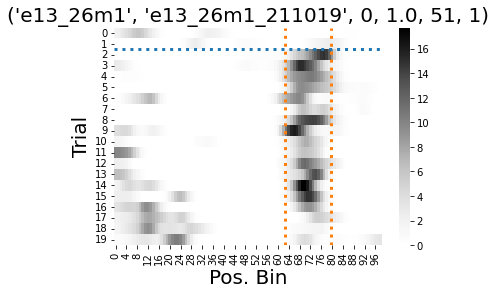

In [260]:
task_ind=0
data_sub=data.loc['sw',ani,sess,task_ind]
ma=data_sub.loc[:,1:2].mean(axis=1) <-2

ii_l = [1]#[0,4,5]

for ii in ii_l:
    row=data_sub.loc[ma].iloc[ii]
#     task_ind,tt,uid,field_id=row.name
    tt,uid,field_id=row.name

    print(row)
    if tt=='both':
        ttr=0
    else:
        ttr=tt

    field_bound = all_fields_recombined_all.loc[ani,sess,task_ind,tt,uid,field_id][['start','end']]
    sw_trial=all_sw_d_all.loc[ani,sess,task_ind].query('trialtype==@tt&uid==@uid&field_index==@field_id')['index_within'].iloc[0]
    fig,ax=ph.ratemap_one_raw(fr_map_trial_df_all.loc[ani,sess,task_ind,ttr,uid].T.dropna(axis=0,how='all'),
                       trial=sw_trial,field_bound=field_bound,
                      )
    ax.set_title((ani,sess,task_ind,tt,uid,field_id))
#     xticks=np.arange(0,99,10)
#     ax.set_xticks(xticks)
#     ax.set_xticklabels(xticks)
    ax.set(xlabel='Pos. Bin',ylabel='Trial')
    for fmt in ['svg','png']:
        fn_full = f'{sess}_task{int(task_ind)}_tt{tt}_uid{uid}_field{field_id}.{fmt}'
#         fig.savefig(os.path.join(figdirsupp,fn_full),bbox_inches='tight')

# ax.set_ylim([sw_trial+5,sw_trial-1])
# ax.set_xlim([field_bound[0]-20,field_bound[1]+20])

0     0.0
1    -2.0
2     0.0
3    -1.0
4    15.0
Name: (0, 0.0, 110, 0), dtype: float64


/tmp/ipykernel_129530/1366318361.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  data_sub=data.loc['nosw',ani,sess]
/tmp/ipykernel_129530/1366318361.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  fig,ax=ph.heatmap(fr_map_trial_df_all.loc[ani,sess,task_ind,ttr,uid].T.dropna(axis=0,how='all'),vmax_quantile=1.)


Text(0.5, 1.0, "('e13_26m1', 'e13_26m1_211019', 0, 0.0, 110, 0)")

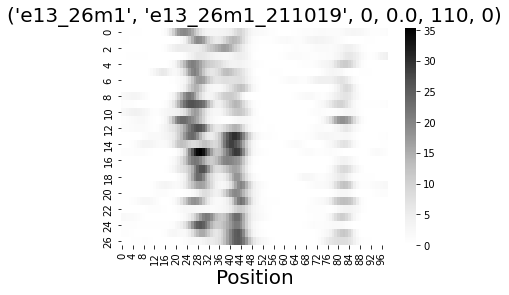

In [178]:
data_sub=data.loc['nosw',ani,sess]
ma=data_sub.mean(axis=1) >2
ii=2
row=data_sub.loc[ma].iloc[ii]
task_ind,tt,uid,field_id=row.name

print(row)
if tt=='both':
    ttr=0
else:
    ttr=tt
fig,ax=ph.heatmap(fr_map_trial_df_all.loc[ani,sess,task_ind,ttr,uid].T.dropna(axis=0,how='all'),vmax_quantile=1.)
ax.set_title((ani,sess,task_ind,tt,uid,field_id))
# ax.set_xlim([50,80])

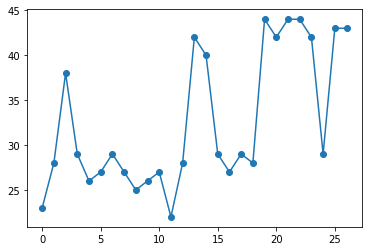

In [179]:
plt.plot(pf_params_recombined_all.loc[ani,sess,'peak',task_ind,tt,uid,field_id].dropna().values,marker='o')


In [181]:
all_fields_recombined_all.loc[ani,sess,task_ind,tt,uid,field_id]

start                       22
end                         47
com                         34
peak                        43
fr_peak              14.435446
fr_mean               9.581959
other_field_index          NaN
Name: (e13_26m1, e13_26m1_211019, 0, 0.0, 110, 0), dtype: object

In [182]:
X_raw_all.loc[ani,sess,task_ind,tt,uid,field_id].dropna().idxmax()

27

In [183]:
X_raw_all.loc[ani,sess,task_ind,tt,uid,field_id].dropna().reset_index(drop=True).idxmax()

15

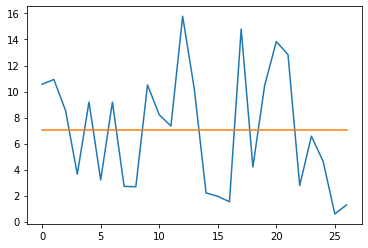

In [129]:
plt.plot(X_raw_all.loc[ani,sess,task_ind,tt,uid,field_id].dropna().values)
plt.plot(X_pwc_all.loc[ani,sess,task_ind,tt,uid,field_id].dropna().values)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

sw_0 vs. sw_1: Mann-Whitney-Wilcoxon test two-sided, P_val:9.465e-05 U_stat=2.116e+05
nosw_0 vs. nosw_1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.509e-27 U_stat=1.520e+06
nosw_0 vs. sw_0: Mann-Whitney-Wilcoxon test two-sided, P_val:2.482e-02 U_stat=3.703e+06
nosw_1 vs. sw_1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.999e-06 U_stat=1.625e+05


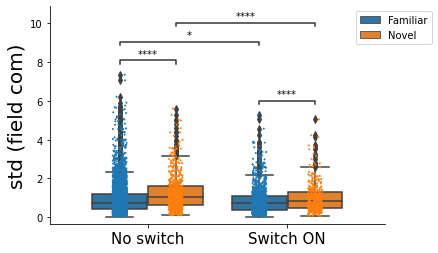

In [370]:
# no filter

x='has_sw'
y=f'{par_key}_{var_func}'
hue='isnovel'


fig,ax=plt.subplots()
data = par_var_nosw_sw_df

sns.stripplot(data=data,x=x,y=y,hue=hue,ax=ax,order=['nosw','sw'],dodge=True,alpha=1,s=2.)

sns.boxplot(data=data,x=x,y=y,hue=hue,ax=ax,order=['nosw','sw'])
sns.despine()
ax.set(ylabel=f'{var_func} (field {par_key})',xlabel='')
ax.set_xticklabels(['No switch','Switch ON'],fontsize=15)

handles,labels=ax.get_legend_handles_labels()
new_labels=['Familiar','Novel']
ax.legend(handles[2:], new_labels,bbox_to_anchor=[0.9,1])

## add test
from statannotations.Annotator import Annotator

# pairs = [(0,2),(1,2),(0,1)]
pairs = [
    (('nosw',0),('sw',0)),
    (('nosw',1),('sw',1)),
    (('nosw',0),('nosw',1)),
    (('sw',0),('sw',1)),
]


annotator = Annotator(ax, pairs, data=data, x=x,hue=hue, y=y)
annotator.configure(test='Mann-Whitney', text_format='star')#, loc='outside')
annotator.apply_and_annotate()

for fmt in ['png','svg']:
#     fig_fn = f'var_{par_key}_vs_sw_fam_nov.{fmt}'
    fig_fn = f'{y}_vs_{x}_hue_{hue}_ntrials_after_sw_{ntrials_after_sw}.{fmt}'
    fig_fn_full = os.path.join(figdir,fig_fn)
    fig.savefig(fig_fn_full,bbox_inches='tight')



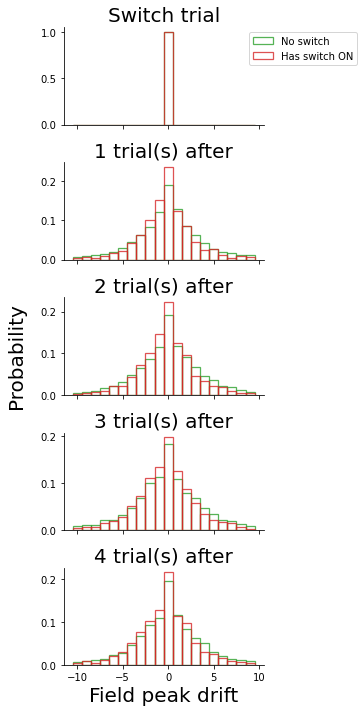

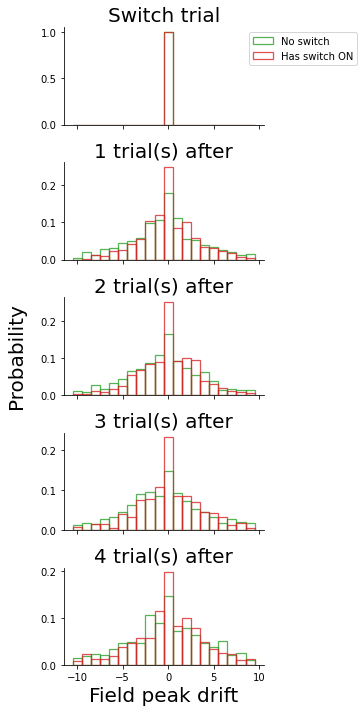

In [274]:
par_nosw_sw_df_relative=par_nosw_sw_df - par_nosw_sw_df[0].values[:,None]

isnovel = 0
for isnovel in [0,1]:
    nplots = par_nosw_sw_df.shape[1]
    fig,axs=plt.subplots(nplots,1,sharex=True,figsize=(5,10))
    bins = np.arange(-10.5,10.5,1)
    c_d = {'nosw':'C2','sw':'C3'}
    for hassw in ['nosw','sw']:
        color=c_d[hassw]
        data=par_nosw_sw_df_relative.loc[(hassw,slice(None),slice(None),isnovel),:]


        for ii,c in enumerate(range(nplots)):
            ax=axs.ravel()[ii]
            sns.histplot(data=data[c],stat='probability',ax=ax,fill=False,bins=bins,alpha=0.8,color=color,label=hassw)
            if c ==0:
                title = 'Switch trial'
            else:
                title = f'{c} trial(s) after'
            ax.set(xlabel='',ylabel='',title=title)
            sns.despine()
    axs[0].legend(['No switch','Has switch ON'],bbox_to_anchor=[0.9,1])
    axs[-1].set(xlabel=f'Field {par_key} drift')
    fig.supylabel('Probability',fontsize=20)
    plt.tight_layout()

    for fmt in ['png','svg']:
        fn_full = f'{par_key}_drift_histogram_isnovel_{isnovel}_ntrials_after_sw_{ntrials_after_sw}.{fmt}'

<Axes: >

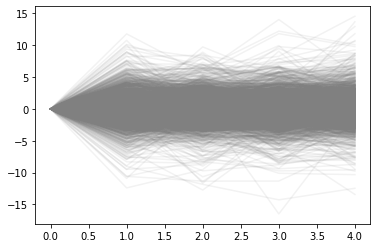

In [376]:
par_nosw_sw_df_relative.loc[('nosw',slice(None),slice(None),0),:].T.plot(color='grey',alpha=0.1,legend=False)



<Axes: >

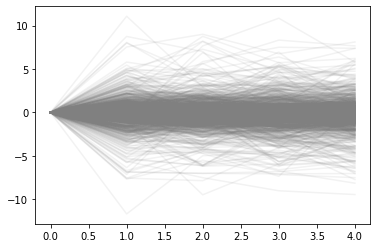

In [375]:
par_nosw_sw_df_relative.loc[('sw',slice(None),slice(None),0),:].T.plot(color='grey',alpha=0.1,legend=False)



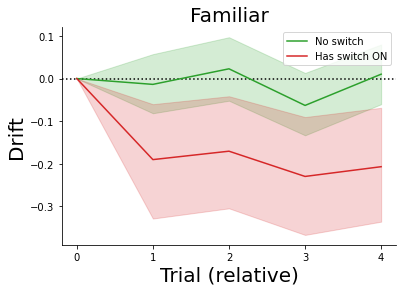

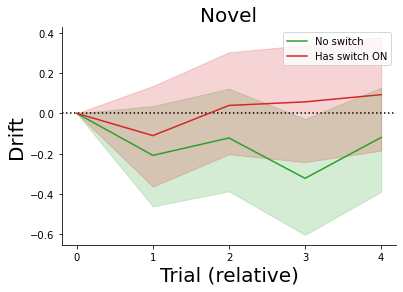

In [446]:
drift_thresh = 5#10
par_nosw_sw_df_relative=par_nosw_sw_df - par_nosw_sw_df[0].values[:,None]
ma=(par_nosw_sw_df_relative.abs()<=drift_thresh).all(axis=1)
data=par_nosw_sw_df_relative.loc[ma]

data_melt=data.groupby(level=(0,3)).apply(lambda x:x.melt()).reset_index(level=(0,1)).rename({'variable':'n_trial_after','value':'drift','level_0':'has_sw','level_1':'isnovel'},axis=1)
data_melt = data_melt.reset_index(drop=True)


palette={'nosw':'C2','sw':'C3'}

isnovel_str_d={0:'Familiar',1:'Novel'}
for isnovel in [0,1]:
    fig,ax=plt.subplots()
    ax.axhline(0,c='k',linestyle=':')
    sns.lineplot(data=data_melt.query('isnovel==@isnovel'),x='n_trial_after',y='drift',hue='has_sw',palette=palette,ax=ax,estimator='mean')
    sns.despine()
    ax.legend(bbox_to_anchor=[0.9,1.])
    ax.set(ylabel='Drift',xlabel='Trial (relative)')
    ax.set(xticks=par_nosw_sw_df.columns)
    ax.set_title(isnovel_str_d[isnovel])
    
    handles,labels=ax.get_legend_handles_labels()
    new_labels=['No switch','Has switch ON']
    ax.legend(handles, new_labels)
    
    
    for fmt in ['png','svg']:
        fn_full = f'{par_key}_drift_vs_trial_ntrials_after_sw_{ntrials_after_sw}_isnovel_{isnovel}_drift_thresh_{drift_thresh}.{fmt}'
        fn_full = os.path.join(figdir,fn_full)
        fig.savefig(fn_full,bbox_inches='tight')




In [78]:
peak_both_sw_fam_nov = get_sw_no_sw_pf_par_var(changes_df_all,pf_params_recombined_all,par_key='peak',min_size=2,half_nosw_trials=True)
fr_peak_both_sw_fam_nov = get_sw_no_sw_pf_par_var(changes_df_all,pf_params_recombined_all,par_key='fr_peak',min_size=2,half_nosw_trials=True)




par_all_both_sw_fam_nov = {'fr_peak':fr_peak_both_sw_fam_nov,'peak':peak_both_sw_fam_nov}

In [177]:
# seperating pop up and non pop up
ma_d = {}
for on_count in [0,1]:
#     ma = ((changes_df_all==1).sum(axis=1)==on_count) & ((changes_df_all==-1).sum(axis=1)==0)
    ma = ((changes_df_all==1).sum(axis=1)==on_count) 
    ma_d[on_count] = ma
    changes_df_all.loc[ma]

# for no sw fields, subselect the stable firing ones
fr_thresh = 1
frac_trial_thresh = 0.9
firing_most_trials=pf_params_recombined_all.loc[(slice(None),slice(None),'fr_peak')].apply(lambda x:(x.dropna()>fr_thresh).mean()>frac_trial_thresh,axis=1) 

# further filter out non firing cells
ma_d[0] = np.logical_and(ma_d[0] ,firing_most_trials)

# # further filter: only fr_peak variance lower than in switched ones
# fr_peak_var_sw_mean=pf_params_recombined_all.loc[(slice(None),slice(None),'fr_peak')].loc[ma_d[1]].var(axis=1).mean()
# ma_sub=pf_params_recombined_all.loc[(slice(None),slice(None),'fr_peak')].loc[ma_d[0]].var(axis=1) <= fr_peak_var_sw_mean
# ma_d[0] = np.logical_and(ma_d[0],ma_sub)




masked=changes_df_all.loc[ma_d[1]].fillna(-0.1)==1
row_ind,col_ind = np.nonzero(masked.values)

par_key = 'peak'#'fr_peak'#

pf_par_on =pf_params_recombined_all.loc[(slice(None),slice(None),par_key)].loc[ma_d[1]]
pf_par_nosw =pf_params_recombined_all.loc[(slice(None),slice(None),par_key)].loc[ma_d[0]]

In [73]:
# prep no sw variables
gpb=pf_par_nosw.groupby(level=(0,1,2,3))
min_size=2 # exclude the first few trials
var_combined={}
for k,val in gpb:
    val = val.loc[k].dropna(axis=1,how='all')
    ntrials = val.shape[1]
    var_combined[k]=val.iloc[:,min_size:(ntrials//2)].var(axis=1)
var_combined = pd.concat(var_combined,axis=0)

pf_par_nosw_var_per_neuron_unstack_halftrial = var_combined.groupby(level=(0,1,2,4)).mean().unstack(level=2).dropna(axis=0)

In [178]:
# prep sw variables
com_after_on_d = {}
com_var_after_on_d = {}
for r,c in zip(row_ind,col_ind):
    com_after_on = pf_par_on.iloc[r,c:].dropna().values
    ind=pf_par_on.index[r]
    com_after_on_d[ind]=pd.Series(com_after_on)
    com_var_after_on_d[ind] = com_after_on.var()

com_after_on_d_df = pd.concat(com_after_on_d,axis=0).unstack(level=-1)
com_var_after_on_d=pd.Series(com_var_after_on_d)
com_var_after_on_d_per_neuron_unstack= com_var_after_on_d.groupby(level=(0,1,2,4)).mean().unstack(level=2).dropna(axis=0)
    
# pf_par_nosw_var = pf_par_nosw.var(axis=1)

# pf_par_nosw_var_per_neuron_unstack=pf_par_nosw_var.groupby(level=(0,1,2,4)).mean().unstack(level=2).dropna(axis=0)

# pf_par_both_sw_fam_nov=pd.concat({'nosw':pf_par_nosw_var_per_neuron_unstack,'sw':com_var_after_on_d_per_neuron_unstack},axis=1)

# combine both
pf_par_both_sw_fam_nov=pd.concat({'nosw':pf_par_nosw_var_per_neuron_unstack_halftrial,'sw':com_var_after_on_d_per_neuron_unstack},axis=1)





In [188]:
com_var_after_on_d.groupby(level=(0,1,2,4)).mean().unstack(level=2).loc[(ani,sess,uid),:]

0         NaN
1    3.972222
Name: (e16_3m2, e16_3m2_211213, 185), dtype: float64

In [186]:
com_var_after_on_d_per_neuron_unstack.loc[(ani,sess),:]

,0,1
11,1.222222,8.000000
19,4.489796,4.187500
26,4.346939,1.763314
34,0.925620,4.666667
55,2.876033,5.158854
61,10.408163,1.360000
66,1.778512,15.554688
93,0.687500,8.765432
100,0.800000,9.691205
124,3.379962,1.000000


In [82]:
par_all_both_sw_fam_nov[par_key].mean()

nosw  0    1.409139
      1    2.094194
sw    0    1.207731
      1    2.167466
dtype: float64

In [95]:
thresh=par_all_both_sw_fam_nov['fr_peak'].mean().loc['sw',0]
par_all_both_sw_fam_nov['fr_peak']

nosw                  sw          
                                     0         1         0         1
e13_26m1 e13_26m1_211019 11   1.013854  1.018802       NaN       NaN
                         27   0.866648  0.584097       NaN       NaN
                         35   0.705121  3.602815       NaN       NaN
                         39   1.883688  3.053702       NaN       NaN
                         41   1.075788  0.975639       NaN       NaN
...                                ...       ...       ...       ...
e16_3m2  e16_3m2_211213  93        NaN       NaN  0.143273  0.532608
                         100       NaN       NaN  0.228242  2.504325
                         124       NaN       NaN  2.396292  2.013789
                         166       NaN       NaN  0.699771  4.704093
                         192       NaN       NaN  0.830085  0.795431

[485 rows x 4 columns]

In [235]:
# subselect low fano factor ones
ma=par_all_both_sw_fam_nov['fr_peak']['nosw'][0] <=thresh
par_all_both_sw_fam_nov['peak'] =pd.concat({'nosw':par_all_both_sw_fam_nov['peak']['nosw'].loc[ma],'sw':par_all_both_sw_fam_nov['peak']['sw']},axis=1)
par_all_both_sw_fam_nov['peak'] = par_all_both_sw_fam_nov['peak'].dropna(axis=0,how='all')                                            
                                            
                                            

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

sw_0 vs. sw_1: Wilcoxon test (paired samples), P_val:4.941e-07 Stat=2.343e+03
nosw_0 vs. nosw_1: Wilcoxon test (paired samples), P_val:1.429e-03 Stat=8.524e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

nosw_0 vs. sw_0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.258e-11 U_stat=2.080e+04
nosw_1 vs. sw_1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.170e-06 U_stat=1.892e+04


(<Axes: ylabel='Var. in field location'>,
  <statannotations.Annotation.Annotation at 0x1551f86fe280>])

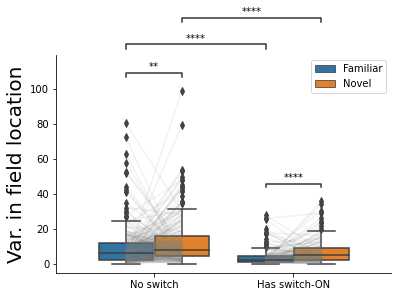

In [105]:

palette = {0: 'C0', 1: 'C1'}
par_key = 'peak'#'fr_peak'#
data=par_all_both_sw_fam_nov[par_key]
pf_par_both_sw_fam_nov_melt=data.melt()


var_0_to_coord={'nosw':0,'sw':1}
var_1_to_coord={0:-0.5,1:0.5}
coord=np.array([var_0_to_coord[x] for x in pf_par_both_sw_fam_nov_melt['variable_0'].values])
coord=coord+np.array([var_1_to_coord[x] for x in pf_par_both_sw_fam_nov_melt['variable_1'].values])
pf_par_both_sw_fam_nov_melt['x_coord'] = coord

ax=sns.boxplot(data=pf_par_both_sw_fam_nov_melt,x='variable_0',y='value',palette=palette,hue='variable_1')

# sns.stripplot(x='variable_0', y='value',hue='variable_1', data=pf_par_both_sw_fam_nov_melt,dodge=True,
#               jitter=False
#              )
# , 
#               markers=["o", "o"], linestyles=["-", "--"])

for _,row in data['nosw'].iterrows():
    ax.plot([-0.2,0.2],row.values,c='grey',alpha=0.1)

for _,row in data['sw'].iterrows():
    ax.plot([1-0.2,1+0.2],row.values,c='grey',alpha=0.1)

sns.despine()
rename_d={'peak':'Var. in field location','fr_peak':'Fano in FR'}
ax.set(xlabel="",xticklabels=['No switch','Has switch-ON'],ylabel=f'{rename_d[par_key]}')

handles,labels=ax.get_legend_handles_labels()
new_labels=['Familiar','Novel']
ax.legend(handles, new_labels)


## add test
from statannotations.Annotator import Annotator

# pairs = [(0,2),(1,2),(0,1)]
pairs = [
    (('nosw',0),('nosw',1)),
    (('sw',0),('sw',1)),
]
data=pf_par_both_sw_fam_nov_melt
annotator = Annotator(ax, pairs, data=data, x='variable_0',hue='variable_1', y='value')
annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
annotator.apply_and_annotate()

pairs=[(('nosw',0),('sw',0)),
    (('nosw',1),('sw',1))]
annotator = Annotator(ax, pairs, data=data, x='variable_0',hue='variable_1', y='value')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()


In [112]:
for fmt in ['png','svg']:
#     fig_fn = f'var_{par_key}_vs_sw_fam_nov.{fmt}'
#     fig_fn = f'var_{par_key}_vs_sw_fam_nov_nohalftrials.{fmt}'
    fig_fn = f'var_{par_key}_vs_sw_fam_nov_nohalftrials_lowfano.{fmt}'
    fig_fn_full = os.path.join(figdir,fig_fn)
    fig.savefig(fig_fn_full,bbox_inches='tight')


In [157]:

from IPython.display import display

nosw  0    27.491667
      1    48.029670
sw    0          NaN
      1          NaN
Name: (e15_13f1, e15_13f1_220118, 46), dtype: float64

,,,,trialtype,field_pos,trial_index,index_within,switch
e15_13f1,e15_13f1_220118,0,25,0.0,19.0,6,3,1.0


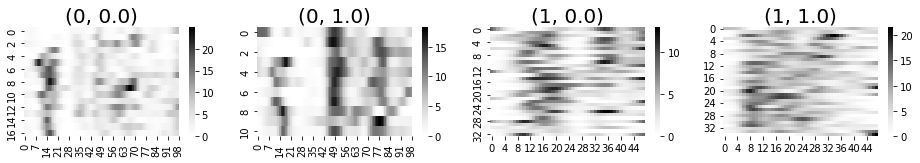

In [252]:
fig,axs=plt.subplots(1,4,figsize=(4*4,2))
rr=200
# one_row = par_all_both_sw_fam_nov['peak']['sw',0].sort_values().iloc[[rr]]
one_row = par_all_both_sw_fam_nov['peak']['nosw',0].sort_values().iloc[[rr]]

ani,sess,uid =one_row.index[0]
var_val=one_row.values[0]
display(par_all_both_sw_fam_nov['peak'].loc[ani,sess,uid])
fr_map_one_uid=fr_map_trial_df_all.loc[(ani,sess,slice(None),slice(None),uid)]
for ii,(tt,fm) in enumerate(fr_map_one_uid.groupby(level=(0,1))):
    ax=axs.ravel()[ii]
    fm = fm.loc[tt].T.dropna(axis=0,how='all')
    sns.heatmap(data=fm,cmap='Greys',ax=ax)
    ax.set(xlabel='')
    ax.set_title(tt)
sw_one=all_sw_d_all.loc[(ani,sess,slice(None)),:].query('uid==@uid')[['trialtype','field_pos','trial_index','index_within','switch']]
display(sw_one)

In [10]:
# center the location relative to beginning

# for no sw
gpb=pf_par_nosw.groupby(level=(0,1,2,3))
no_sw_loc_recentered={}
for k,val in gpb:
    val = val.loc[k].dropna(axis=1,how='all')
    val = val - val.iloc[:,0].values[:,None]
    no_sw_loc_recentered[k] = val
no_sw_loc_recentered = pd.concat(no_sw_loc_recentered,axis=0)

# for sw
com_after_on_d_df_recenter = com_after_on_d_df - com_after_on_d_df.iloc[:,0].values[:,None]

# convert to long format
no_sw_loc_recentered_long=no_sw_loc_recentered.stack().reset_index(level=(2,6)).rename({'level_2':'isnovel','level_6':'trial',0:'location'},axis=1)
com_after_on_d_df_recenter_long = com_after_on_d_df_recenter.stack().reset_index(level=(2,6)).rename({'level_2':'isnovel','level_6':'trial',0:'location'},axis=1)


# combine
loc_recentered_sw_and_nosw = pd.concat({'hassw':com_after_on_d_df_recenter,'nosw':no_sw_loc_recentered},axis=0)
loc_recentered_long_sw_and_nosw=pd.concat({'hassw':com_after_on_d_df_recenter_long,'nosw':no_sw_loc_recentered_long},axis=0)
loc_recentered_long_sw_and_nosw=loc_recentered_long_sw_and_nosw.reset_index(level=0).rename({'level_0':'switch'},axis=1)
trial_cdf=loc_recentered_long_sw_and_nosw.groupby(level=(0,1,2),group_keys=False).apply(lambda x:pd.cut(x['trial'],bins=10,retbins=False,labels=False))
loc_recentered_long_sw_and_nosw['trial_bin'] = trial_cdf.values



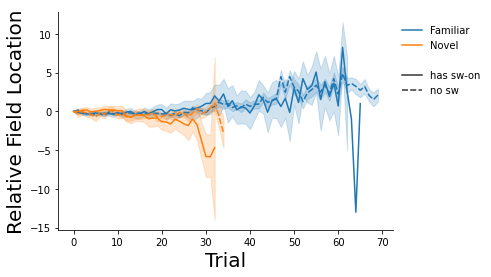

In [339]:
ax=sns.lineplot(data=loc_recentered_long_sw_and_nosw.reset_index(),x='trial',y='location',hue='isnovel',style='switch')
sns.despine()
ax.set(ylabel='Relative Field Location',xlabel='Trial')

handles,labels=ax.get_legend_handles_labels()
new_labels=['','Familiar','Novel','','has sw-on','no sw']
ax.legend(handles, new_labels,bbox_to_anchor=[1,1.05],frameon=False)

fig=ax.figure

for fmt in ['png','svg']:
#     fig_fn = f'var_{par_key}_vs_sw_fam_nov.{fmt}'
    fig_fn = f'relative_{par_key}_vs_trial_sw_fam_nov_nohalftrials.{fmt}'
    fig_fn_full = os.path.join(figdir,fig_fn)
    fig.savefig(fig_fn_full,bbox_inches='tight')




# net peak movement

In [19]:
net_loc_movement = loc_recentered_sw_and_nosw.mean(axis=1).reset_index(level=(0,3)).rename({'level_0':'switch','level_3':'isnovel'},axis=1)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

hassw_0 vs. hassw_1: Mann-Whitney-Wilcoxon test two-sided, P_val:7.371e-03 U_stat=3.451e+05
nosw_0 vs. nosw_1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.753e-02 U_stat=3.210e+06
nosw_0 vs. hassw_0: Mann-Whitney-Wilcoxon test two-sided, P_val:9.787e-02 U_stat=5.538e+06
nosw_1 vs. hassw_1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.002e-04 U_stat=1.772e+05


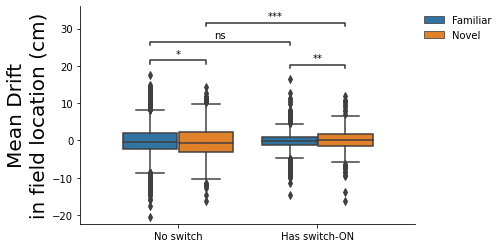

In [28]:
data=net_loc_movement
order=['nosw','hassw']
ax=sns.boxplot(data=data,x='switch',y=0,hue='isnovel',order=order)

## add test
from statannotations.Annotator import Annotator

# pairs = [(0,2),(1,2),(0,1)]
pairs = [
    (('nosw',0),('nosw',1)),
    (('hassw',0),('hassw',1)),
    (('nosw',0),('hassw',0)),
    (('nosw',1),('hassw',1))
]

data=data
annotator = Annotator(ax, pairs, data=data, x='switch',hue='isnovel', y=0,order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

sns.despine()
rename_d={'peak':'location','fr_peak':'FR'}
ax.set(xlabel="",xticklabels=['No switch','Has switch-ON'],ylabel=f'Mean Drift\nin field {rename_d[par_key]} (cm)')

handles,labels=ax.get_legend_handles_labels()
new_labels=['Familiar','Novel']
ax.legend(handles, new_labels,bbox_to_anchor=[1,1],frameon=False)

fig=ax.figure

for fmt in ['png','svg']:
#     fig_fn = f'var_{par_key}_vs_sw_fam_nov.{fmt}'
    fig_fn = f'mean_drift_vs_trial_sw_fam_nov_nohalftrials.{fmt}'
    fig_fn_full = os.path.join(figdir,fig_fn)
    fig.savefig(fig_fn_full,bbox_inches='tight')



In [36]:
data.groupby(['switch','isnovel'])[0].agg(mean='mean',std='std')


mean       std
switch isnovel                    
hassw  0       -0.179192  2.428945
       1        0.125601  3.129035
nosw   0       -0.234118  3.761724
       1       -0.452004  4.376535

In [252]:
corr_with_trial = loc_recentered.apply(lambda x:pd.Series(scipy.stats.pearsonr(x.dropna().values,np.arange(len(x.dropna()))),index=['corr','pval']),axis=1)





/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/sta

In [255]:
ma=corr_with_trial['corr'] > 0.5

<Axes: >

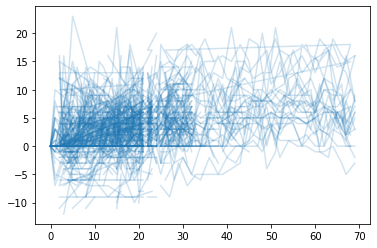

In [256]:
loc_recentered.loc[ma].T.plot(legend=False,alpha=0.2,c='C0')

<Axes: >

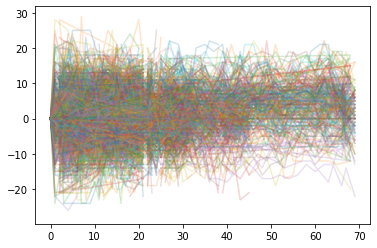

In [240]:
loc_recentered.T.plot(legend=False,alpha=0.2)

In [102]:
scipy.stats.wilcoxon(pf_par_nosw_var_per_neuron_unstack[0],pf_par_nosw_var_per_neuron_unstack[1])



WilcoxonResult(statistic=102078.0, pvalue=2.1653144998929126e-17)

In [106]:
scipy.stats.ranksums(pf_par_nosw_var_per_neuron_unstack[0],com_var_after_on_d_per_neuron_unstack[0])
scipy.stats.ranksums(pf_par_nosw_var_per_neuron_unstack[1],com_var_after_on_d_per_neuron_unstack[1])
scipy.stats.ranksums(pf_par_nosw_var_per_neuron_unstack[0],com_var_after_on_d_per_neuron_unstack[1])


RanksumsResult(statistic=11.588236810596182, pvalue=4.727643599358813e-31)

<Axes: xlabel='0', ylabel='1'>

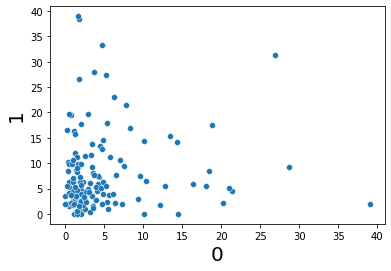

In [76]:
sns.scatterplot(data=com_var_after_on_d_per_neuron_unstack,x=0,y=1)

In [92]:
scipy.stats.wilcoxon(com_var_after_on_d_per_neuron_unstack[0],com_var_after_on_d_per_neuron_unstack[1])



WilcoxonResult(statistic=2505.0, pvalue=2.915423783142516e-06)

In [79]:
row=com_var_after_on_d_per_neuron_unstack.loc[com_var_after_on_d_per_neuron_unstack[0]>30]
ani,sess,uid=row.index[0]
row

,,,0,1
e15_13f1,e15_13f1_220118,312,39.0,1.933498


In [42]:
pf_par_on.iloc[row_ind,col_ind]

33         18         8   \
e13_26m1 e13_26m1_210913 0 0.0  3  0  31.978647        NaN        NaN   
                                36 2  85.678709  85.060861  85.241289   
                                40 1  95.326069  94.456831  94.975998   
                                43 1  33.770258  33.419641  30.613218   
                                57 0   6.985005        NaN        NaN   
...                                         ...        ...        ...   
e14_2m3  e14_2m3_201118  0 0.0  4  0        NaN        NaN  85.578902   
                                34 0        NaN        NaN  96.260307   
                                35 0        NaN        NaN  37.262096   
                                50 1        NaN        NaN  37.762101   
                           both 22 0        NaN   8.970418   9.776419   

                                             12         27         65  \
e13_26m1 e13_26m1_210913 0 0.0  3  0        NaN        NaN  31.760727   
                                36 2  80.389635  84.795621  83.861930   
                                40 1  94.699807  95.156890  95.043927   
                                43 1  34.043993  31.809882  32.602485   
                                57 0        NaN   7.054445   6.040315   
...                                         ...        ...        ...   
e14_2m3  e14_2m3_201118  0 0.0  4  0  87.386033        NaN        NaN   
                                34 0  96.296405        NaN        NaN   
                                35 0        NaN        NaN        NaN   
                                50 1  33.879461        NaN        NaN   
                           both 22 0   7.957126        NaN        NaN   

                                             51         27         29  \
e13_26m1 e13_26m1_210913 0 0.0  3  0  34.470870        NaN        NaN   
                                36 2  83.406488  84.795621  85.185474   
                                40 1  96.033711  95.156890  95.355121   
                                43 1  35.024257  31.809882  33.006603   
                                57 0   7.505509   7.054445   6.840963   
...                                         ...        ...        ...   
e14_2m3  e14_2m3_201118  0 0.0  4  0        NaN        NaN        NaN   
                                34 0        NaN        NaN        NaN   
                                35 0        NaN        NaN        NaN   
                                50 1        NaN        NaN        NaN   
                           both 22 0        NaN        NaN        NaN   

                                             33  ...        15         19  \
e13_26m1 e13_26m1_210913 0 0.0  3  0  31.978647  ...       NaN        NaN   
                                36 2  85.678709  ...       NaN        NaN   
                                40 1  95.326069  ...       NaN        NaN   
                                43 1  33.770258  ...       NaN        NaN   
                                57 0   6.985005  ...       NaN        NaN   
...                                         ...  ...       ...        ...   
e14_2m3  e14_2m3_201118  0 0.0  4  0        NaN  ...       NaN  86.952281   
                                34 0        NaN  ...       NaN  96.304237   
                                35 0        NaN  ...       NaN  40.807641   
                                50 1        NaN  ...       NaN  34.261943   
                           both 22 0        NaN  ...  8.975597   9.079849   

                                            9          18         18  \
e13_26m1 e13_26m1_210913 0 0.0  3  0       NaN        NaN        NaN   
                                36 2       NaN  85.060861  85.060861   
                                40 1       NaN  94.456831  94.456831   
                                43 1       NaN  33.419641  33.419641   
                                57 0       NaN        NaN        NaN   
...                                        ...        ...

In [9]:
all_fields_one = all_fields_recombined_all.loc[ani,sess]
fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]

/tmp/ipykernel_787914/384936139.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields_one = all_fields_recombined_all.loc[ani,sess]
/tmp/ipykernel_787914/384936139.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]


In [12]:
for tt,all_fields_one_tt in all_fields_one.groupby(level=(0,1)):
    all_fields_one_tt = all_fields_one_tt.loc[tt]
    fr_map_trial_df_one_tt = fr_map_trial_df.loc[tt]
    all_fields_ratemap_trial = get_all_fields_ratemap_trial(all_fields_one_tt, fr_map_trial_df_one_tt)
    sim_per_field_all_trialpairs = all_fields_ratemap_trial.groupby(level=(0,1)).apply(lambda x:x.corr())
    sim_per_field_elapsed_trials = sim_per_field_all_trialpairs.groupby(level=(0,1)).apply(agg_similarity_by_elapsed_trial)

KeyError: 'both'

/tmp/ipykernel_787914/1285034253.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax=sns.heatmap(fr_map_trial_df_all.loc[(ani,sess,isnovel),:].loc[tt].loc[uid].dropna(axis=1,how='all').T,cmap='Greys',ax=ax)


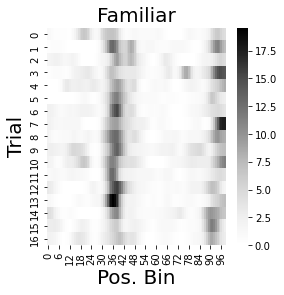

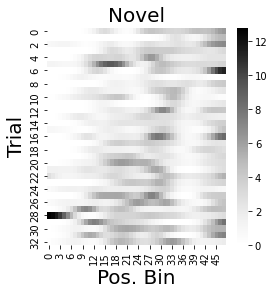

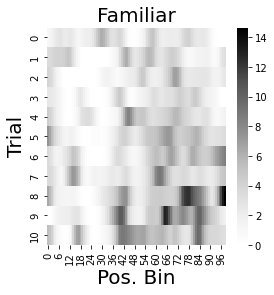

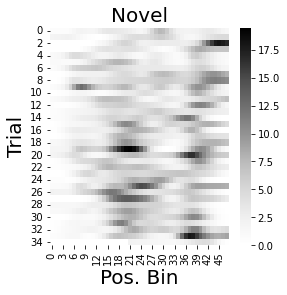

In [81]:
# uid=142
dosavefig = False#True
isnovel_str_d = {0:'Familiar',1:'Novel'}
for tt in [0,1]:
    for isnovel in [0,1]:
        fig,ax=plt.subplots(figsize=(4,4))
        ax=sns.heatmap(fr_map_trial_df_all.loc[(ani,sess,isnovel),:].loc[tt].loc[uid].dropna(axis=1,how='all').T,cmap='Greys',ax=ax)
        ax.set_xlabel('Pos. Bin')
        ax.set_ylabel('Trial')
        ax.set_title(isnovel_str_d[isnovel])
        if dosavefig:
            for fmt in ['png','svg']:
                fig_fn = f'ratemap_{uid}_task_{isnovel}_tt_{tt}.{fmt}'
                fig_fn_full = os.path.join(figdir_ex,fig_fn)
                fig.savefig(fig_fn_full,bbox_inches='tight')



/tmp/ipykernel_787914/3148114071.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df_all.loc[(ani,sess,0),:].loc[1].loc[uid].dropna(axis=1,how='all').mean(axis=1).plot()


<Axes: >

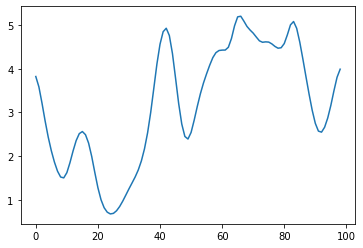

In [84]:
fr_map_trial_df_all.loc[(ani,sess,0),:].loc[1].loc[uid].dropna(axis=1,how='all').mean(axis=1).plot()